In [21]:
import joblib
import numpy as np
from hyperopt import Trials
from torch.optim import Adam
from models.load_data import DataLoader
from models.RNN import StockLSTM, train, evaluate, validate, evaluate_roll
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = 'data'
AAPL_TRAIN = 'aapl_train.csv'
AAPL_TEST = 'aapl_test.csv'
MSFT_TRAIN = 'msft_train.csv'
MSFT_TEST = 'msft_test.csv'

LOG_PATH = 'log'

In [3]:
def get_trials(dataset:str, model:str, mode:str) -> Trials:
    _model = 'StockLSTM' if model == 'lstm' else 'StockGRU'
    return joblib.load(f"{LOG_PATH}/{dataset}_{_model}_{mode}_optim.joblib")

运行 hyper_params.py 进行两阶段调参

第一阶段(model mode)：

固定 lr = 1e-3, batch_size = 240, epochs = 2000

调参 look_back, hidden_dim, num_layers

第二阶段(train mode)：

选取一阶段中的最优参数，调参 lr, batch_size, epochs

最终最优参数如下：

In [25]:
# AAPL_LSTM
t_m = get_trials('aapl', 'lstm', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('aapl', 'lstm', 'train')
print(f"epochs = {t_t.argmin['epochs']}")
print(f"batch_size = {t_t.argmin['batch_size']}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid log(MSE) = {t_t.average_best_error()}")

hidden_dim = 30
look_back = 20
num_layers = 1
epochs = 2502
batch_size = 249
lr = 0.002735836335696231

best valid log(MSE) = 0.21642068028450012


In [26]:
# AAPL_GRU
t_m = get_trials('aapl', 'gru', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('aapl', 'gru', 'train')
print(f"epochs = {t_t.argmin['epochs']}")
print(f"batch_size = {t_t.argmin['batch_size']}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid log(MSE) = {t_t.average_best_error()}")

hidden_dim = 39
look_back = 21
num_layers = 2
epochs = 1923
batch_size = 220
lr = 0.0016414158725463054

best valid log(MSE) = 0.17277750372886658


In [27]:
# MSFT_LSTM
t_m = get_trials('msft', 'lstm', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('msft', 'lstm', 'train')
print(f"epochs = {t_t.argmin['epochs']}")
print(f"batch_size = {t_t.argmin['batch_size']}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid log(MSE) = {t_t.average_best_error()}")

hidden_dim = 33
look_back = 27
num_layers = 1
epochs = 2475
batch_size = 205
lr = 0.0007629533569853219

best valid log(MSE) = -0.3308381140232086


In [28]:
# MSFT_GRU
t_m = get_trials('msft', 'gru', 'model')
for key in t_m.argmin:
    print(f"{key} = {t_m.argmin[key]}")
t_t = get_trials('msft', 'gru', 'train')
print(f"epochs = {t_t.argmin['epochs']}")
print(f"batch_size = {t_t.argmin['batch_size']}")
print(f"lr = {t_t.argmin['lr']}")
print(f"\nbest valid log(MSE) = {t_t.average_best_error()}")

hidden_dim = 39
look_back = 20
num_layers = 1
epochs = 1949
batch_size = 224
lr = 0.0010455494194061702

best valid log(MSE) = -0.06145591661334038


两个数据集对应的最优模型，在全训练集上进行训练，并在测试集上评估

In [8]:
# AAPL_GRU
a_m = get_trials('aapl', 'gru', 'model').argmin
a_t = get_trials('aapl', 'gru', 'train').argmin
trainLoader = DataLoader(f"{DATA_PATH}/{AAPL_TRAIN}", a_m['look_back'], random_state=2030)
model = StockLSTM(a_m['hidden_dim'], a_m['num_layers'])
optimizer = Adam(model.parameters(), lr=a_t['lr'])
# optimizer = Adam(model.parameters(), lr=2e-3)
_, _, record = train(model, trainLoader, a_t['epochs'], a_t['batch_size'], optimizer, show_every=100)
# _, _, record = train(model, trainLoader, 2000, a_t['batch_size'], optimizer, show_every=100)

Epoch 99/1923: MSE = 0.8975736498832703
Epoch 199/1923: MSE = 0.8294558525085449
Epoch 299/1923: MSE = 0.6755610108375549
Epoch 399/1923: MSE = 0.436267226934433
Epoch 499/1923: MSE = 0.3451562225818634
Epoch 599/1923: MSE = 0.12736263871192932
Epoch 699/1923: MSE = 0.0356045737862587
Epoch 799/1923: MSE = 0.025806626304984093
Epoch 899/1923: MSE = 0.003595431800931692
Epoch 999/1923: MSE = 0.00264522316865623
Epoch 1099/1923: MSE = 0.0021112870890647173
Epoch 1199/1923: MSE = 0.0012241321383044124
Epoch 1299/1923: MSE = 0.0006911434466019273
Epoch 1399/1923: MSE = 0.00022678595269098878
Epoch 1499/1923: MSE = 0.00041595136281102896
Epoch 1599/1923: MSE = 0.001948370598256588
Epoch 1699/1923: MSE = 0.0004935645847581327
Epoch 1799/1923: MSE = 0.000196911467355676
Epoch 1899/1923: MSE = 2.081074853776954e-05
traing process finished in 122.466 seconds.
final MSE score = 1.8913522580987774e-05


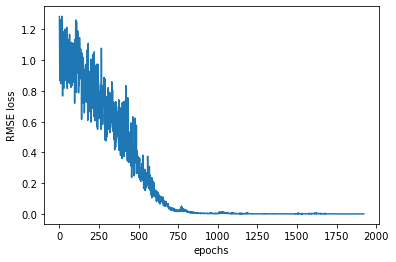

In [9]:
plt.xlabel('epochs')
plt.ylabel('RMSE loss')
plt.plot(record[:, 0], record[:, 1])

In [10]:
from sklearn.metrics import r2_score

MSE = 1.478676199913025
R2 = -0.2458831331946405


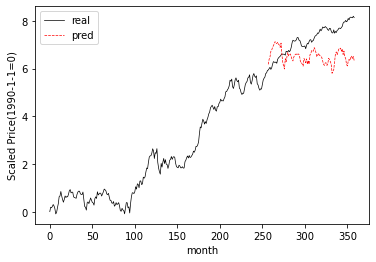

In [11]:
# 在测试集上评估
model.eval()
testLoader = DataLoader(
    f"{DATA_PATH}/{AAPL_TEST}",
    look_back=a_m['look_back'],
    train=False,
    train_params=trainLoader.getTrainParams(),
)
Xtest, ytest = testLoader.getTestData()
ypred = model.predict(Xtest, periods=len(ytest)).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

alldata = alldata.cumsum()
ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate(model, testLoader)}")
print(f"R2 = {evaluate(model, testLoader, r2_score)}")

R2为负值意味着预测器表现不如平均值预测器(简单对往期数据取平均)

我也挣扎过了，确实如此(捂脸)

MSE = 1.8135093450546265
R2 = -0.3556253803515481


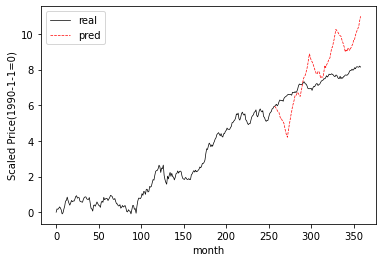

In [16]:
# 滚动预测
Xtest, ytest = testLoader.getRollTestData()
ypred = model(Xtest).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

alldata = alldata.cumsum()
ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate_roll(model, testLoader)}")
print(f"R2 = {evaluate_roll(model, testLoader, r2_score)}")

In [17]:
# MSFT_LSTM
a_m = get_trials('msft', 'lstm', 'model').argmin
a_t = get_trials('msft', 'lstm', 'train').argmin
trainLoader = DataLoader(f"{DATA_PATH}/{MSFT_TRAIN}", a_m['look_back'], random_state=2030)
model = StockLSTM(a_m['hidden_dim'], a_m['num_layers'])
optimizer = Adam(model.parameters(), lr=a_t['lr'])
# optimizer = Adam(model.parameters(), lr=2e-3)
_, _, record = train(model, trainLoader, a_t['epochs'], a_t['batch_size'], optimizer, show_every=100)
# _, _, record = train(model, trainLoader, 6000, a_t['batch_size'], optimizer, show_every=100)

Epoch 99/2475: MSE = 0.9693911671638489
Epoch 199/2475: MSE = 0.8600354194641113
Epoch 299/2475: MSE = 0.7221126556396484
Epoch 399/2475: MSE = 0.8139373064041138
Epoch 499/2475: MSE = 0.6528588533401489
Epoch 599/2475: MSE = 0.6717851758003235
Epoch 699/2475: MSE = 0.41262567043304443
Epoch 799/2475: MSE = 0.42514148354530334
Epoch 899/2475: MSE = 0.4962446391582489
Epoch 999/2475: MSE = 0.35820555686950684
Epoch 1099/2475: MSE = 0.2819712460041046
Epoch 1199/2475: MSE = 0.28969353437423706
Epoch 1299/2475: MSE = 0.33775460720062256
Epoch 1399/2475: MSE = 0.2854311168193817
Epoch 1499/2475: MSE = 0.2632441818714142
Epoch 1599/2475: MSE = 0.1685631424188614
Epoch 1699/2475: MSE = 0.16638968884944916
Epoch 1799/2475: MSE = 0.13345442712306976
Epoch 1899/2475: MSE = 0.08477059006690979
Epoch 1999/2475: MSE = 0.06822287291288376
Epoch 2099/2475: MSE = 0.09102434664964676
Epoch 2199/2475: MSE = 0.06644944846630096
Epoch 2299/2475: MSE = 0.0881570428609848
Epoch 2399/2475: MSE = 0.052069891

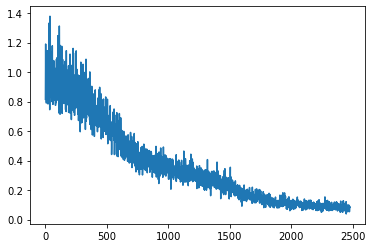

In [18]:
plt.plot(record[:, 0], record[:, 1])

MSE = 1.5462075471878052
R2 = -0.5094561439682381


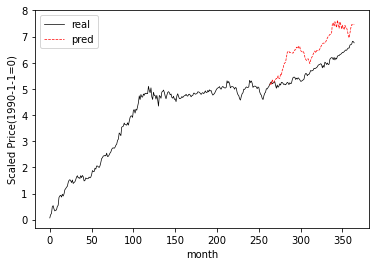

In [24]:
# 在测试集上评估
model.eval()
trainLoader = DataLoader(
    f"{DATA_PATH}/{MSFT_TRAIN}",
    look_back=a_m['look_back']
)
testLoader = DataLoader(
    f"{DATA_PATH}/{MSFT_TEST}",
    look_back=a_m['look_back'],
    train=False,
    train_params=trainLoader.getTrainParams(),
)
Xtest, ytest = testLoader.getTestData()
ypred = model.predict(Xtest, periods=len(ytest)).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

alldata = alldata.cumsum()
ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate(model, testLoader)}")
print(f"R2 = {evaluate(model, testLoader, r2_score)}")

MSE = 2.412914276123047
R2 = -0.554337138642496


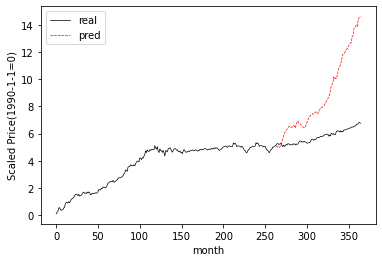

In [23]:
# 滚动预测
Xtest, ytest = testLoader.getRollTestData()
ypred = model(Xtest).detach().numpy()
ypred = trainLoader.scaler.inverse_transform(ypred.reshape(-1, 1)).flatten()
alldata = np.r_[trainLoader._data.flatten(), testLoader._data.flatten()]
times = np.arange(len(alldata))

alldata = alldata.cumsum()
ypred = ypred.cumsum() + alldata[-len(ypred)-1]

plt.plot(times, alldata, 'k-', lw=0.7, label='real')
plt.plot(times[-len(ypred):], ypred, 'r--', lw=0.7, label='pred')
plt.legend()
plt.xlabel("month")
plt.ylabel("Scaled Price(1990-1-1=0)")
print(f"MSE = {evaluate_roll(model, testLoader)}")
print(f"R2 = {evaluate_roll(model, testLoader, r2_score)}")